# 2022年 世界モデル第6回演習 B
この演習では, **Decision Transformer** [[1]](#scrollTo=DIsL-5NdT7yE) を実装し, [**PyBullet**](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.2ye70wns7io3)の環境で学習させていきます.  

1. [準備](#scrollTo=eFq-izzvz5Z_)
2. [Decision Transformerの復習](#scrollTo=n1QIwsI60UFl)
3. [Decision Transformerの実装](#scrollTo=Z9NnTyCRkwXw)
4. [SequenceTrainerクラスの実装](#scrollTo=CUglxkc44DcD)
5. [評価関数の実装](#scrollTo=lrylNTKRzybQ)
6. [実験を行うための関数の実装](#scrollTo=NKIOiqXK0kZj)
7. [実行](#scrollTo=x_f-etU5m_go)
8. [参考文献](#scrollTo=DIsL-5NdT7yE)

## 1.準備

演習を行うための準備をしていきましょう.

まず, 予め用意した他のエージェントの軌跡データと, `trajectory_gpt2.py` がこの.ipynbファイルと同じディレクトリに配置されていることを確認してください.

In [2]:
!pip install transformers==4.5.1
!pip install pybullet

!apt update
!apt install xvfb
!pip install gym-notebook-wrapper

     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 76.8 MB/s 
     |████████████████████████████████| 895 kB 86.6 MB/s 
     |████████████████████████████████| 90.8 MB 442 bytes/s 
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubu

In [3]:
import gym
import pybullet_envs
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import argparse
import pickle
import random
import sys
import os
import time
from datetime import datetime, timezone, timedelta
import gnwrapper

import transformers

# Gymの警告を一部無視する．
gym.logger.set_level(40)
# matplotlibをColab上で描画するためのコマンド．
%matplotlib inline

GPT2モデルをインポートします.

In [4]:
# Google DriveをColabにマウント
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# 自分が配置したディレクトリを指定してください.
work_dir = '/content/drive/MyDrive/world_model_edu-main/第6回'

os.chdir(work_dir)
print(os.getcwd())

from trajectory_gpt2 import *

Mounted at /content/drive
/content/drive/MyDrive/world_model_edu-main/第6回


ランタイムをGPUに変更していますか？　GPUを利用できているか，きちんと確認しましょう．

In [1]:
!nvidia-smi

Sun Dec 26 11:25:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    47W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.__version__

'1.10.0+cu111'

## 2.Decision Transformerの復習  

**Decision Transformerのアーキテクチャ**

<p align='center'><img src='https://github.com/kzl/decision-transformer/blob/master/architecture.png?raw=True' width='70%'></p>

Decision Transformerは, GPT2を用いて時系列データ

$$
\tau = (\hat{R}_1, s_1, a_1, \hat{R}_2, s_2, a_2,..., \hat{R}_T, s_T, a_T)
$$

を学習します.

$\hat{R}$は未来の収益(return-to-go)で, これと状態と行動の同時分布を, 自己回帰的にモデリングします.

- Return-to-go

$$
\hat{R}_t = \sum^T_{t'=t}r_{t'}
$$

時刻tの状態, 行動, Return-to-goのセットを一つのトークンとし, Causal Transformerに入力します.

評価時には, 現在の状態, 目的報酬（人間が決めた定数）, そして過去の情報から, 次ステップで取る行動を予測させます.

## 3.Decision Transformerの実装

演習Aで実装した通常のGPT-2ではなく, Decision Transformerの筆者らが実装したGPT-2を用います.

これが通常のGPT-2と異なるのは, 1つのタイムステップが3つのトークンに対応する特殊なpositional embeddingを行う, という点だけです.

**モデルのアルゴリズム**

<p align='center'><img src='https://github.com/SeanNobel/world_model/blob/main/algorithm_1.png?raw=True' width='60%'></p>

In [5]:
class DecisionTransformer(nn.Module):
    
    def __init__(self, state_dim, act_dim, hidden_size, max_length=None, max_ep_len=4096,
            action_tanh=True, **kwargs):
        super().__init__()

        self.state_dim = state_dim
        self.act_dim = act_dim
        self.max_length = max_length

        self.hidden_size = hidden_size
        config = transformers.GPT2Config(
            # 語彙サイズはDecisionTransformerには関係ないので1
            vocab_size=1,
            n_embd=hidden_size,
            **kwargs
        )

        # Positional embeddingが取り除かれたGPT-2モデルをロード
        self.transformer = GPT2Model(config)

        self.embed_timestep = nn.Embedding(max_ep_len, hidden_size)
        # 収益, 状態, 行動のembedding表現を得るための全結合層
        self.embed_return = torch.nn.Linear(1, hidden_size)
        self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
        self.embed_action = torch.nn.Linear(self.act_dim, hidden_size)

        self.embed_ln = nn.LayerNorm(hidden_size)

        # 論文ではstateとreturnは予測させていないのであとで消すかも
        # self.predict_state = torch.nn.Linear(hidden_size, self.state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(hidden_size, self.act_dim)] + ([nn.Tanh()] if action_tanh else []))
        )
        # self.predict_return = torch.nn.Linear(hidden_size, 1)

    def forward(self, states, actions, rewards, returns_to_go, timesteps, attention_mask=None):

        batch_size, seq_length = states.shape[0], states.shape[1]

        if attention_mask is None:
            # attention mask for GPT: 1 if can be attended to, 0 if not
            attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long)

        # 状態, 行動, 収益, 時間をそれぞれ違うヘッドでembeddingする
        state_embeddings = self.embed_state(states)
        action_embeddings = self.embed_action(actions)
        returns_embeddings = self.embed_return(returns_to_go)
        time_embeddings = self.embed_timestep(timesteps)

        # Positioinal encodingと同じように, time embeddingをそれぞれに足す
        state_embeddings = state_embeddings + time_embeddings
        action_embeddings = action_embeddings + time_embeddings
        returns_embeddings = returns_embeddings + time_embeddings

        # ここで (R_1, s_1, a_1, R_2, s_2, a_2, ...) というシークエンスを作ります.
        # 状態が行動の前にあることで, 自己回帰モデル的には状態が行動を予測するようになる点が良い
        stacked_inputs = torch.stack(
            (returns_embeddings, state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(batch_size, 3*seq_length, self.hidden_size)
        stacked_inputs = self.embed_ln(stacked_inputs)

        # 上で作った時系列データ同様, attention maskも交互にスタックします
        stacked_attention_mask = torch.stack(
            (attention_mask, attention_mask, attention_mask), dim=1
        ).permute(0, 2, 1).reshape(batch_size, 3*seq_length)

        # GPT-2では単語の辞書内での番号をモデルに入れていましたが（多くのNLPも同様）,
        # DTではembedding表現をモデルに入れます
        transformer_outputs = self.transformer(
            inputs_embeds=stacked_inputs,
            attention_mask=stacked_attention_mask,
        )
        x = transformer_outputs['last_hidden_state']

        # (R_t, s_t, a_t) の順番に戻す
        x = x.reshape(batch_size, seq_length, 3, self.hidden_size).permute(0, 2, 1, 3)

        # 現在の状態と行動を受け取って次の収益を予測する
        return_preds = self.predict_return(x[:,2])
        # 現在の状態と行動を受け取って次の状態を予測する
        state_preds = self.predict_state(x[:,2])
        # 現在の状態を受け取って次の行動を予測する
        action_preds = self.predict_action(x[:,1])

        return state_preds, action_preds, return_preds

    def get_action(self, states, actions, rewards, returns_to_go, timesteps, **kwargs):

        states = states.reshape(1, -1, self.state_dim)
        actions = actions.reshape(1, -1, self.act_dim)
        returns_to_go = returns_to_go.reshape(1, -1, 1)
        timesteps = timesteps.reshape(1, -1)

        if self.max_length is not None:
            states = states[:,-self.max_length:]
            actions = actions[:,-self.max_length:]
            returns_to_go = returns_to_go[:,-self.max_length:]
            timesteps = timesteps[:,-self.max_length:]

            # pad all tokens to sequence length
            attention_mask = torch.cat([torch.zeros(self.max_length-states.shape[1]), torch.ones(states.shape[1])])
            attention_mask = attention_mask.to(dtype=torch.long, device=states.device).reshape(1, -1)
            states = torch.cat(
                [torch.zeros((states.shape[0], self.max_length-states.shape[1], self.state_dim), device=states.device), states],
                dim=1).to(dtype=torch.float32)
            actions = torch.cat(
                [torch.zeros((actions.shape[0], self.max_length - actions.shape[1], self.act_dim),
                             device=actions.device), actions],
                dim=1).to(dtype=torch.float32)
            returns_to_go = torch.cat(
                [torch.zeros((returns_to_go.shape[0], self.max_length-returns_to_go.shape[1], 1), device=returns_to_go.device), returns_to_go],
                dim=1).to(dtype=torch.float32)
            timesteps = torch.cat(
                [torch.zeros((timesteps.shape[0], self.max_length-timesteps.shape[1]), device=timesteps.device), timesteps],
                dim=1
            ).to(dtype=torch.long)
        else:
            attention_mask = None

        _, action_preds, return_preds = self.forward(
            states, actions, None, returns_to_go, timesteps, attention_mask=attention_mask, **kwargs)

        return action_preds[0,-1]

## 4.SequenceTrainerクラスの実装

ここでは, `max_iter`の回数だけ`get_batch()`によるデータ収集, 学習, 評価を行う`SequenceTrainer`クラスを実装します.

**学習アルゴリズム**

<p align='center'><img src='https://github.com/SeanNobel/world_model/blob/main/algorithm_2.png?raw=True' width='60%'></p>

In [6]:
class SequenceTrainer:

    def __init__(self, model, optimizer, batch_size, get_batch, loss_fn, scheduler=None, eval_fns=None):
        self.model = model
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.get_batch = get_batch
        self.loss_fn = loss_fn
        self.scheduler = scheduler
        self.eval_fns = [] if eval_fns is None else eval_fns
        self.diagnostics = dict()

        self.start_time = time.time()

    def train_iteration(self, num_steps, iter_num=0, print_logs=False):

        train_losses = []
        logs = dict()

        train_start = time.time()

        self.model.train()
        for _ in range(num_steps):
            train_loss = self.train_step()
            train_losses.append(train_loss)
            if self.scheduler is not None:
                self.scheduler.step()

        logs['time/training'] = time.time() - train_start

        eval_start = time.time()

        self.model.eval()
        for eval_fn in self.eval_fns:
            outputs = eval_fn(self.model)
            for k, v in outputs.items():
                logs[f'evaluation/{k}'] = v

        logs['time/total'] = time.time() - self.start_time
        logs['time/evaluation'] = time.time() - eval_start
        logs['training/train_loss_mean'] = np.mean(train_losses)
        logs['training/train_loss_std'] = np.std(train_losses)

        for k in self.diagnostics:
            logs[k] = self.diagnostics[k]

        if print_logs:
            print('=' * 80)
            print(f'Iteration {iter_num}')
            for k, v in logs.items():
                print(f'{k}: {v}')

        return logs

    def train_step(self):
        # データ収集
        states, actions, rewards, dones, rtg, timesteps, attention_mask = self.get_batch(self.batch_size)
        action_target = torch.clone(actions)

        state_preds, action_preds, reward_preds = self.model.forward(
            states, actions, rewards, rtg[:,:-1], timesteps, attention_mask=attention_mask,
        )

        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_target = action_target.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]

        loss = self.loss_fn(
            None, action_preds, None,
            None, action_target, None,
        )

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), .25)
        self.optimizer.step()

        with torch.no_grad():
            self.diagnostics['training/action_error'] = torch.mean((action_preds-action_target)**2).detach().cpu().item()

        return loss.detach().cpu().item()

## 5.評価関数の実装

**評価アルゴリズム**

<p align='center'><img src='https://github.com/SeanNobel/world_model/blob/main/algorithm_3.png?raw=True' width='60%'></p>

In [7]:
def evaluate_episode_rtg(env, state_dim, act_dim, model, max_ep_len=1000, scale=1000.,
        state_mean=0., state_std=1., device='cuda', target_return=None, mode='normal',
        visualize=False):

    model.eval()
    model.to(device=device)

    state_mean = torch.from_numpy(state_mean).to(device=device)
    state_std = torch.from_numpy(state_std).to(device=device)

    state = env.reset()
    if mode == 'noise':
        state = state + np.random.normal(0, 0.1, size=state.shape)

    # we keep all the histories on the device
    # note that the latest action and reward will be "padding"
    states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)

    ep_return = target_return
    target_return = torch.tensor(ep_return, device=device, dtype=torch.float32).reshape(1, 1)
    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)

    sim_states = []

    episode_return, episode_length = 0, 0
    for t in range(max_ep_len):

        # add padding
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])

        action = model.get_action(
            (states.to(dtype=torch.float32) - state_mean) / state_std,
            actions.to(dtype=torch.float32),
            rewards.to(dtype=torch.float32),
            target_return.to(dtype=torch.float32),
            timesteps.to(dtype=torch.long),
        )
        actions[-1] = action
        action = action.detach().cpu().numpy()

        state, reward, done, _ = env.step(action)

        cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        rewards[-1] = reward

        if mode != 'delayed':
            pred_return = target_return[0,-1] - (reward/scale)
        else:
            pred_return = target_return[0,-1]
        target_return = torch.cat(
            [target_return, pred_return.reshape(1, 1)], dim=1)
        timesteps = torch.cat(
            [timesteps,
             torch.ones((1, 1), device=device, dtype=torch.long) * (t+1)], dim=1)

        episode_return += reward
        episode_length += 1

        if done:
            break

    if visualize:
        return env
    else:
        return episode_return, episode_length

## 6.実験を行うための関数の実装

再掲, return-to-goは割引ではありません: $\hat{R}_t = \sum^T_{t'=t}r_{t'}$

In [8]:
# 割引報酬和の計算. gamma=1なので実質割引ではない
def discount_cumsum(x, gamma):
    discount_cumsum = np.zeros_like(x)
    discount_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        discount_cumsum[t] = x[t] + gamma * discount_cumsum[t+1]
    return discount_cumsum

In [9]:
# メインループを回す関数
def experiment(exp_prefix, params, dataset_path):
    device = params.get('device', 'cuda')

    env_name, dataset = params['env'], params['dataset']
    group_name = f'{exp_prefix}-{env_name}-{dataset}'
    exp_prefix = f'{group_name}-{random.randint(int(1e5), int(1e6) - 1)}'

    print(f'Starting new experiment: {env_name} {dataset}')
    print(datetime.now(timezone(timedelta(hours=9))))

    if env_name == 'hopper':
        env = gym.make('HopperBulletEnv-v0')
        env_targets = [3600, 1800]  # evaluation conditioning targets
    elif env_name == 'halfcheetah':
        env = gym.make('HalfCheetahBulletEnv-v0')
        env_targets = [12000, 6000]
    elif env_name == 'walker2d':
        env = gym.make('Walker2DBulletEnv-v0')
        env_targets = [5000, 2500]
    else:
        raise NotImplementedError

    max_ep_len = params.get('max_ep_len', 1000)
    # 報酬のスケールをノーマライズする値
    scale = 1000.

    # 状態空間, 行動空間の次元数を取得
    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    print('=' * 50)
    # pickle形式で用意した別エージェントの軌跡データをロード
    with open(dataset_path, 'rb') as f:
        trajectories = pickle.load(f)

        print(f"軌跡の本数: {len(trajectories)}")
        print(f"状態空間の次元数: {trajectories[0]['observations'].shape[1]}")
        print(f"行動空間の次元数: {trajectories[0]['actions'].shape[1]}")

    # すべての軌跡情報（報酬, 状態, 行動, ステップ数）を, 各々のリストに保存
    mode = params.get('mode', 'normal')
    states, traj_lens, returns = [], [], []
    for path in trajectories:
        # 遅延報酬にする場合, すべての報酬を軌跡の最後尾に移動する
        if mode == 'delayed':
            path['rewards'][-1] = path['rewards'].sum()
            path['rewards'][:-1] = 0.
        states.append(path['observations'])
        # 各軌跡の実際の長さ(<1000)を保存
        traj_lens.append(len(path['observations']))
        # 各軌跡の報酬の和を保存
        returns.append(path['rewards'].sum())
    traj_lens, returns = np.array(traj_lens), np.array(returns)

    # 長さの異なる状態の軌跡を一本にまとめる
    states = np.concatenate(states, axis=0)
    state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

    # すべての軌跡の長さを足した値
    num_timesteps = sum(traj_lens)

    print(f'総タイムステップ数（{len(trajectories)}本の合計）: {num_timesteps}')
    print(f'Return 平均: {np.mean(returns):.2f}, 標準偏差: {np.std(returns):.2f}')
    print(f'最大 return: {np.max(returns):.2f}, 最小 return: {np.min(returns):.2f}')
    print('=' * 50)

    K = params['K']
    batch_size = params['batch_size']
    num_eval_episodes = params['num_eval_episodes']
    pct_traj = params.get('pct_traj', 1.)

    # only train on top pct_traj trajectories (for %BC experiment)
    # %BCのためのものなのであとで書き換える
    num_timesteps = max(int(pct_traj*num_timesteps), 1)
    # 軌跡データを報酬が低かったものから順に並び替えるためのインデックス
    sorted_inds = np.argsort(returns)
    num_trajectories = 1
    timesteps = traj_lens[sorted_inds[-1]]
    ind = len(trajectories) - 2
    while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
        timesteps += traj_lens[sorted_inds[ind]]
        num_trajectories += 1
        ind -= 1
    sorted_inds = sorted_inds[-num_trajectories:] # pct_traj=1.0でも, ここで軌跡が1ステップ短くなっている

    # used to reweight sampling so we sample according to timesteps instead of trajectories
    p_sample = traj_lens[sorted_inds] / sum(traj_lens[sorted_inds])

    def get_batch(batch_size=256, max_len=K):
        batch_inds = np.random.choice(
            np.arange(num_trajectories),
            size=batch_size,
            replace=True,
            p=p_sample,  # reweights so we sample according to timesteps
        )

        # dはエピソード終了のタイミングを表すdone（終了時1, その他0）を保存する
        # rtg: return-to-go
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        for i in range(batch_size):
            traj = trajectories[int(sorted_inds[batch_inds[i]])]
            si = random.randint(0, traj['rewards'].shape[0] - 1)

            # get sequences from dataset
            s.append(traj['observations'][si:si + max_len].reshape(1, -1, state_dim))
            a.append(traj['actions'][si:si + max_len].reshape(1, -1, act_dim))
            r.append(traj['rewards'][si:si + max_len].reshape(1, -1, 1))
            if 'terminals' in traj:
                d.append(traj['terminals'][si:si + max_len].reshape(1, -1))
            else:
                d.append(traj['dones'][si:si + max_len].reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= max_ep_len] = max_ep_len-1  # padding cutoff
            rtg.append(discount_cumsum(traj['rewards'][si:], gamma=1.)[:s[-1].shape[1] + 1].reshape(1, -1, 1))
            if rtg[-1].shape[1] <= s[-1].shape[1]:
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, max_len - tlen, state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - state_mean) / state_std
            a[-1] = np.concatenate([np.ones((1, max_len - tlen, act_dim)) * -10., a[-1]], axis=1)
            r[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), rtg[-1]], axis=1) / scale
            timesteps[-1] = np.concatenate([np.zeros((1, max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).to(dtype=torch.float32, device=device)
        a = torch.from_numpy(np.concatenate(a, axis=0)).to(dtype=torch.float32, device=device)
        r = torch.from_numpy(np.concatenate(r, axis=0)).to(dtype=torch.float32, device=device)
        d = torch.from_numpy(np.concatenate(d, axis=0)).to(dtype=torch.long, device=device)
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).to(dtype=torch.float32, device=device)
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).to(dtype=torch.long, device=device)
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).to(device=device)

        return s, a, r, d, rtg, timesteps, mask

    def eval_episodes(target_rew):
        def fn(model):
            returns, lengths = [], []
            for _ in range(num_eval_episodes):
                with torch.no_grad():
                    ret, length = evaluate_episode_rtg(env, state_dim, act_dim, model,
                        max_ep_len=max_ep_len, scale=scale, target_return=target_rew/scale,
                        mode=mode, state_mean=state_mean, state_std=state_std, device=device,)
                returns.append(ret)
                lengths.append(length)
            return {
                f'target_{target_rew}_return_mean': np.mean(returns),
                f'target_{target_rew}_return_std': np.std(returns),
                f'target_{target_rew}_length_mean': np.mean(lengths),
                f'target_{target_rew}_length_std': np.std(lengths),
            }
        return fn

    model = DecisionTransformer(
        state_dim=state_dim,
        act_dim=act_dim,
        max_length=K,
        max_ep_len=max_ep_len,
        hidden_size=params['embed_dim'],
        n_layer=params['n_layer'],
        n_head=params['n_head'],
        n_inner=4*params['embed_dim'],
        activation_function=params['activation_function'],
        n_positions=1024,
        resid_pdrop=params['dropout'],
        attn_pdrop=params['dropout'],
    ).to(device)

    # 最初から高い学習率を用いるのではなく, warmup_stepsステップをかけて最初徐々に学習率を
    # 上げていくというトリックが使われています. これによりバッチサイズの増加に伴う学習精度の急落を
    # ある程度防ぐことができます.
    warmup_steps = params['warmup_steps']
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=params['learning_rate'],
        weight_decay=params['weight_decay'],
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda steps: min((steps+1)/warmup_steps, 1)
    )

    trainer = SequenceTrainer(
        model=model,
        optimizer=optimizer,
        batch_size=batch_size,
        get_batch=get_batch,
        scheduler=scheduler,
        loss_fn=lambda s_hat, a_hat, r_hat, s, a, r: torch.mean((a_hat - a)**2),
        eval_fns=[eval_episodes(tar) for tar in env_targets],
    )

    for iter in range(params['max_iters']):
        outputs = trainer.train_iteration(num_steps=params['num_steps_per_iter'], iter_num=iter+1, print_logs=True)
        if iter == 0:
            logs = outputs
            for key in logs.keys(): logs[key] = [logs[key]]
        else:
            for key in logs.keys(): logs[key].append(outputs[key])

    print(f"Training ended {datetime.now(timezone(timedelta(hours=9)))}")

    return trainer.model, state_mean, state_std, env_targets, scale, logs

## 7.実行

In [11]:
params = {
    'env': 'halfcheetah', # 'halfcheetah' or 'hopper' or 'walker2d'
    'dataset': 'PPO_session1',
    'mode': 'normal', # 'delayed'だとTransformerの本領が発揮されるかもしれない？
    'max_ep_len': 1000,
    'K': 20, # 各バッチの系列長
    'pct_traj': 1.,
    'batch_size': 64,
    # 'model_type': 'dt', # decision transformer
    'embed_dim': 128,
    'n_layer': 3,
    'n_head': 1,
    'activation_function': 'relu',
    'dropout': 0.1,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'warmup_steps': 10000,
    'num_eval_episodes': 100,
    'max_iters': 10,
    'num_steps_per_iter': 10000,
    'device': 'cuda',
}

env_name = params['env']; dataset_type = params['dataset']
dataset_path = work_dir + f'/trajectories/{env_name}-bullet-{dataset_type}-v0.pkl'

model_path = work_dir + '/trained_model/halfcheetah-trained_2.pth'

学習を行う場合に実行してください.

In [ ]:
trained_model, state_mean, state_std, target_return, scale, logs = \
        experiment('gym-experiment', params=params, dataset_path=dataset_path)

# モデルのパラメータの保存
torch.save(trained_model.state_dict(), model_path)

Starting new experiment: halfcheetah PPO_session1
2021-12-26 20:29:17.491925+09:00
軌跡の本数: 1999
状態空間の次元数: 26
行動空間の次元数: 6
総タイムステップ数（1999本の合計）: 1000000
Return 平均: 1098.52, 標準偏差: 1124.19
最大 return: 2267.96, 最小 return: -1002.54
Iteration 1
time/training: 392.26782298088074
evaluation/target_12000_return_mean: -1297.9640203506776
evaluation/target_12000_return_std: 61.52766376806271
evaluation/target_12000_length_mean: 1000.0
evaluation/target_12000_length_std: 0.0
evaluation/target_6000_return_mean: -1300.1819548901087
evaluation/target_6000_return_std: 57.042932389222614
evaluation/target_6000_length_mean: 1000.0
evaluation/target_6000_length_std: 0.0
time/total: 1423.69602394104
time/evaluation: 1031.4281947612762
training/train_loss_mean: 0.06556276402077638
training/train_loss_std: 0.13594528648550136
training/action_error: 0.009229450486600399
Iteration 2
time/training: 388.90027809143066
evaluation/target_12000_return_mean: -1339.240420885613
evaluation/target_12000_return_std: 214.02

(参考)  
`params['mode']`を`'delayed'`にして学習を行ってみてください. これにより, すべての報酬が各エピソードの最後に与えられるというスパースな設定になります. これまでのTD学習による強化学習では成績が著しく下がるのですが, Decision Transformerは成績を維持することがわかると思います.

<p align='center'><img src='https://github.com/SeanNobel/world_model/blob/main/sparse_reward.png?raw=True' width='50%'></p>

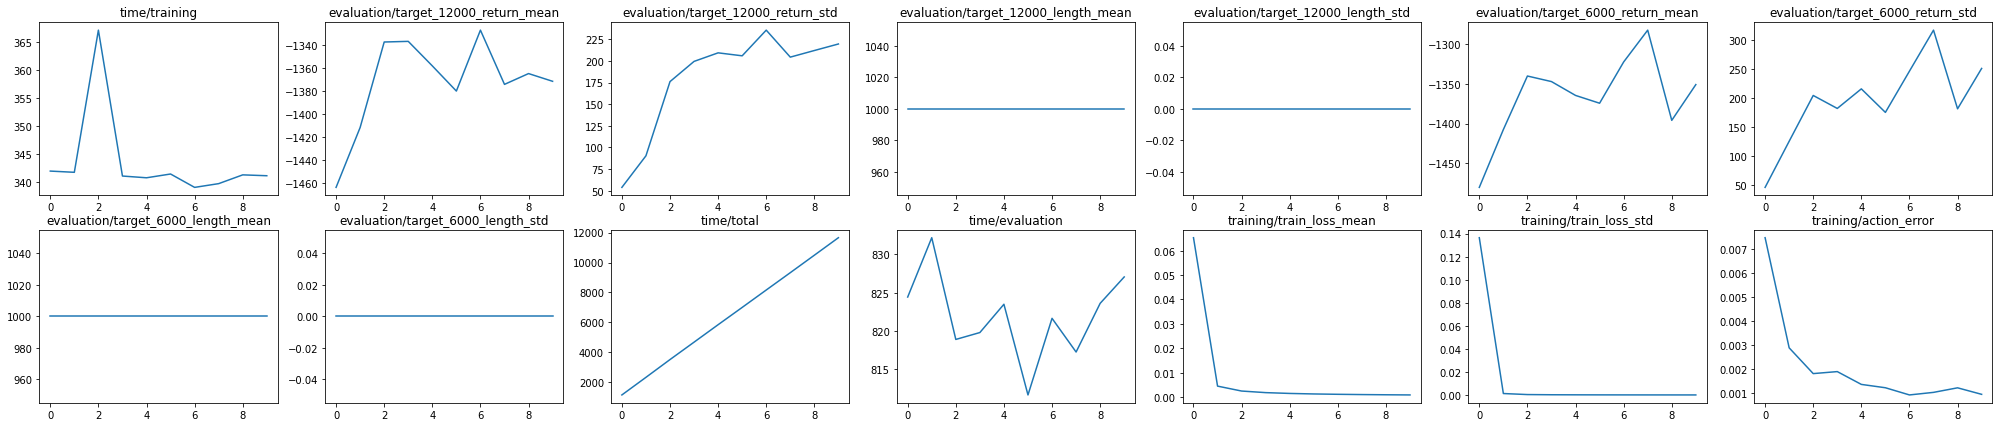

In [ ]:
fig, ax = plt.subplots(2, 7, figsize=(35, 7))
for i, key in zip(range(14), logs.keys()):
    ax[i//7, i%7].plot(range(len(logs[key])), logs[key])
    ax[i//7, i%7].set_title(key)

In [68]:
# 学習を行った場合はFalseにしてください.
# 学習で出力したばかりのパラメータを読み込む場合は, ドライブをマウントしなおしてください.
use_saved_model = True

if params['env'] == 'hopper':
    monitor_env = gym.make('HopperBulletEnv-v0')
elif params['env'] == 'halfcheetah':
    monitor_env = gym.make('HalfCheetahBulletEnv-v0')
elif params['env'] == 'walker2d':
    monitor_env = gym.make('Walker2DBulletEnv-v0')
else:
    raise NotImplementedError


if use_saved_model:

    trained_model = DecisionTransformer(
        state_dim=monitor_env.observation_space.shape[0],
        act_dim=monitor_env.action_space.shape[0],
        max_length=params['K'],
        max_ep_len=params['max_ep_len'],
        hidden_size=params['embed_dim'],
        n_layer=params['n_layer'],
        n_head=params['n_head'],
        n_inner=4*params['embed_dim'],
        activation_function=params['activation_function'],
        n_positions=1024,
        resid_pdrop=params['dropout'],
        attn_pdrop=params['dropout'],
    ).to(params['device'])

    # trained_model.load_state_dict(torch.load(model_path))
    trained_model.load_state_dict(torch.load(work_dir + '/trained_model/test.pth'))


monitor_env = gnwrapper.Monitor(monitor_env, size=(400, 300), directory='.', force=True,
                                video_callable=lambda ep: True)

monitor_env = evaluate_episode_rtg(monitor_env, monitor_env.observation_space.shape[0],
                    monitor_env.action_space.shape[0], trained_model, params['max_ep_len'],
                    scale, state_mean, state_std, params.get('device', 'cuda'), target_return[0]/scale,
                    params.get('mode', 'normal'), visualize=True)

monitor_env.display()

del monitor_env

'openaigym.video.8.73.video000000.mp4'

## 8.参考文献

[[1]](https://arxiv.org/abs/2106.01345) Chen, Lili, et al. "Decision Transformer: Reinforcement Learning via Sequence Modeling." arXiv preprint arXiv:2106.01345 (2021).